<a href="https://colab.research.google.com/github/Sid3503/NoProp/blob/main/NoProp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup Libraries

In [1]:
!pip install torch torchvision

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 53.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 58.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 45.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 837.9 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 92.1 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitl

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Hyperparameters

In [22]:
# Hyperparameters
T = 10  # Diffusion steps
embed_dim = 10  # Label embedding dimension(No. of Classes)
batch_size = 128
lr = 0.001
epochs = 50

In [4]:
# Noise schedule (linear)
alpha = torch.linspace(1.0, 0.1, T)  # α_t from 1.0 → 0.1

In [6]:
print(alpha)

tensor([1.0000, 0.9000, 0.8000, 0.7000, 0.6000, 0.5000, 0.4000, 0.3000, 0.2000,
        0.1000])


# Setting Up Models

In [7]:
# MLP for denoising
class DenoisingMLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.Linear(128 + embed_dim, 256),  # Input: image features + noisy label
            nn.ReLU(),
            nn.Linear(256, embed_dim)        # Output: denoised label
        )

    def forward(self, x_features, z_t):
        combined = torch.cat([x_features, z_t], dim=1)
        return self.mlp(combined)

In [8]:
# CNN for image features
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 32, 3, 1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, 1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Flatten(),
            nn.Linear(1600, 128)  # MNIST: 28x28 → 1600-dim
        )

    def forward(self, x):
        return self.features(x)

In [9]:
# Initialize models
cnn = CNN()
mlps = nn.ModuleList([DenoisingMLP() for _ in range(T)])  # One MLP per layer
optimizers = [optim.Adam(mlp.parameters(), lr=lr) for mlp in mlps]

In [55]:
cnn

CNN(
  (features): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=1600, out_features=128, bias=True)
  )
)

In [56]:
mlps

ModuleList(
  (0-9): 10 x DenoisingMLP(
    (mlp): Sequential(
      (0): Linear(in_features=138, out_features=256, bias=True)
      (1): ReLU()
      (2): Linear(in_features=256, out_features=10, bias=True)
    )
  )
)

# Preparing Dataset

In [10]:
# Load MNIST
transform = transforms.ToTensor()
train_data = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)

100%|██████████| 9.91M/9.91M [00:02<00:00, 4.56MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 65.1kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.26MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 6.77MB/s]


# Training

---

### **NoProp Training Dry Run (1 Epoch Example)**


# 🧪 NoProp Training Dry Run (1 Epoch)

Let's simulate **one epoch** of training with:
- Batch size = 3
- Classes = 3 ("cat", "dog", "bird")
- Diffusion steps (T) = 2

## 📥 Batch Data
**Input (x):** 3 images  
**Labels (y):** ["cat"=0, "dog"=1, "bird"=2]  
→ One-hot encoded `u_y`:
```
tensor([
 [1., 0., 0.],  # cat
 [0., 1., 0.],  # dog
 [0., 0., 1.]   # bird
])
```

---

## 🌪️ Forward Diffusion (Corrupt Labels)
**Noise schedule (α):** [α₀=1.0, α₁=0.6, α₂=0.3]  
1. **t=0:** `z₀ = u_y` (clean)

2. **t=1:**  
   `z₁ = √0.6*z₀ + √0.4*noise` ≈
```
tensor([
 [0.77, 0.20, 0.03],  # noisy cat
 [0.10, 0.85, 0.05],  # noisy dog
 [0.05, 0.10, 0.85]   # noisy bird
])
```


3. **t=2:**  
   `z₂ = √0.3*z₁ + √0.7*noise` ≈

```
tensor([
 [0.40, 0.35, 0.25],  # very noisy cat
 [0.25, 0.45, 0.30],  # very noisy dog
 [0.20, 0.25, 0.55]   # very noisy bird
])
```

---

**Example for MLP1 (t=1):**
- **Input:** Image features + `z₁ = [0.77,0.20,0.03]` (noisy cat)
- **Prediction:** `[0.9, 0.1, 0.0]` (should approach `[1,0,0]`)
- **Loss:** MSE([0.9,0.1,0.0], [1,0,0]) = 0.01

## 🔄 Weight Updates
1. Sum losses from all MLPs → `total_loss`
2. Backpropagate → Update all MLPs independently

## 📊 Epoch Output
`Epoch 1/10 | Avg Loss: 0.85`  
*(Loss decreases as MLPs learn to denoise better)*

---

### **Key Takeaways**
1. **Diffusion**: Labels are progressively noised from clean → random.
2. **Specialization**: Each MLP handles a specific noise level.
3. **Independence**: No backprop between layers → parallel training.

In [23]:
# Training loop
for epoch in range(epochs):
    epoch_loss = 0.0
    batch_count = 0

    for x, y in train_loader:
        current_batch_size = x.shape[0]
        u_y = torch.zeros(current_batch_size, embed_dim).scatter_(1, y.unsqueeze(1), 1)

        # Forward diffusion(Adding Noise for each 'T')
        z = [u_y]
        for t in range(1, T + 1):
            eps = torch.randn_like(u_y)
            z_t = torch.sqrt(alpha[t-1]) * z[-1] + torch.sqrt(1 - alpha[t-1]) * eps
            z.append(z_t)

        # Train MLPs
        x_features = cnn(x)
        losses = []
        for t in range(T):
            u_hat = mlps[t](x_features, z[t+1].detach())
            losses.append(torch.mean((u_hat - u_y) ** 2))

        total_loss = sum(losses)
        for opt in optimizers:
            opt.zero_grad()
        total_loss.backward()
        for opt in optimizers:
            opt.step()

        epoch_loss += total_loss.item()
        batch_count += 1

    # Epoch summary print
    avg_loss = epoch_loss / batch_count
    print(f"Epoch {epoch+1}/{epochs} | Avg Loss: {avg_loss:.4f}")

# Final message
print("Training complete!")

Epoch 1/50 | Avg Loss: 0.0835
Epoch 2/50 | Avg Loss: 0.0819
Epoch 3/50 | Avg Loss: 0.0806
Epoch 4/50 | Avg Loss: 0.0791
Epoch 5/50 | Avg Loss: 0.0778
Epoch 6/50 | Avg Loss: 0.0766
Epoch 7/50 | Avg Loss: 0.0753
Epoch 8/50 | Avg Loss: 0.0744
Epoch 9/50 | Avg Loss: 0.0734
Epoch 10/50 | Avg Loss: 0.0725
Epoch 11/50 | Avg Loss: 0.0714
Epoch 12/50 | Avg Loss: 0.0706
Epoch 13/50 | Avg Loss: 0.0700
Epoch 14/50 | Avg Loss: 0.0692
Epoch 15/50 | Avg Loss: 0.0685
Epoch 16/50 | Avg Loss: 0.0677
Epoch 17/50 | Avg Loss: 0.0671
Epoch 18/50 | Avg Loss: 0.0664
Epoch 19/50 | Avg Loss: 0.0660
Epoch 20/50 | Avg Loss: 0.0654
Epoch 21/50 | Avg Loss: 0.0648
Epoch 22/50 | Avg Loss: 0.0643
Epoch 23/50 | Avg Loss: 0.0637
Epoch 24/50 | Avg Loss: 0.0631
Epoch 25/50 | Avg Loss: 0.0627
Epoch 26/50 | Avg Loss: 0.0621
Epoch 27/50 | Avg Loss: 0.0617
Epoch 28/50 | Avg Loss: 0.0615
Epoch 29/50 | Avg Loss: 0.0614
Epoch 30/50 | Avg Loss: 0.0604
Epoch 31/50 | Avg Loss: 0.0600
Epoch 32/50 | Avg Loss: 0.0596
Epoch 33/50 | Avg

# Inferencing

In [24]:
# Inference (denoising)
def predict(x):
    z_t = torch.randn(1, embed_dim)  # Start from noise
    x_features = cnn(x.unsqueeze(0))
    for t in reversed(range(T)):
        u_hat = mlps[t](x_features, z_t)
        z_t = torch.sqrt(alpha[t]) * u_hat + torch.sqrt(1 - alpha[t]) * torch.randn_like(u_hat)
    return torch.argmax(z_t)  # Final prediction

In [48]:
# Test on an example
x_test, y_test = next(iter(train_loader))
pred = predict(x_test[0])
print(f"Predicted: {pred}, True: {y_test[0]}")

Predicted: 1, True: 1


In [29]:
import matplotlib.pyplot as plt
import numpy as np

def plot_prediction(x, true_label, pred_label, class_names=None):
    """
    Plot image with true and predicted labels.

    Args:
        x (torch.Tensor): Input image tensor (1, C, H, W)
        true_label (int): Ground truth class index
        pred_label (int): Predicted class index
        class_names (list): Optional list of class names
    """
    # Convert tensor to numpy and denormalize if needed
    img = x.squeeze().cpu().numpy()
    if img.min() < 0 or img.max() > 1:  # Assuming [0,1] or [-1,1] range
        img = (img - img.min()) / (img.max() - img.min())

    # Create figure
    plt.figure(figsize=(6, 3))

    # Plot image
    plt.subplot(1, 2, 1)
    plt.imshow(img, cmap='gray' if img.ndim == 2 else None)
    plt.axis('off')
    plt.title('Input Image', pad=10)

    # Plot labels
    plt.subplot(1, 2, 2)
    plt.axis('off')

    if class_names:
        true_str = f"True: {class_names[true_label]} ({true_label})"
        pred_str = f"Predicted: {class_names[pred_label]} ({pred_label})"
    else:
        true_str = f"True label: {true_label}"
        pred_str = f"Predicted: {pred_label}"

    plt.text(0.1, 0.7, true_str, fontsize=12, color='green')
    plt.text(0.1, 0.5, pred_str,
             fontsize=12,
             color='red' if true_label != pred_label else 'green')

    # Highlight incorrect predictions
    if true_label != pred_label:
        plt.text(0.1, 0.3, "INCORRECT", fontsize=14, color='red', weight='bold')

    plt.tight_layout()
    plt.show()

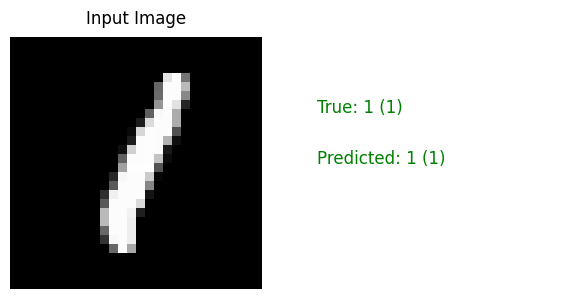

In [57]:
# Example usage with MNIST
class_names = [str(i) for i in range(10)]  # ['0', '1', ..., '9']
x_test, y_test = next(iter(train_loader))
pred = predict(x_test[0])

plot_prediction(x_test[0],
               y_test[0].item(),
               pred.item(),
               class_names)